# Cox-PH and DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [30]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [31]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [32]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [33]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [34]:
df_train


,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0
...,...,...,...,...,...,...,...,...,...,...,...
1894,6.663192,5.876152,10.036640,6.208500,1.0,1.0,0.0,1.0,66.570000,107.366669,1
1896,6.932373,5.986949,9.777548,5.886733,0.0,0.0,0.0,0.0,43.750000,182.600006,1
1901,5.901610,5.272237,14.200950,6.139390,0.0,0.0,0.0,1.0,57.770000,37.866665,1
1902,6.818109,5.372744,11.652624,6.077852,1.0,0.0,0.0,1.0,58.889999,198.433334,0


## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [35]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [36]:
x_mapper

DataFrameMapper(drop_cols=[],
                features=[(['x0'], StandardScaler()),
                          (['x1'], StandardScaler()),
                          (['x2'], StandardScaler()),
                          (['x3'], StandardScaler()),
                          (['x8'], StandardScaler()), ('x4', None),
                          ('x5', None), ('x6', None), ('x7', None)])

In [37]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [38]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [39]:
y_val

(array([ 85.73333  ,  55.666668 , 143.6      , 117.       , 183.2      ,
        151.9      ,  37.8      , 128.36667  , 141.56667  ,   2.5333333,
        225.5      ,  21.9      , 174.56667  , 130.46666  , 113.566666 ,
         34.3      , 163.1      , 111.53333  , 128.2      ,  17.833334 ,
         55.733334 , 226.7      , 239.16667  , 168.26666  , 176.36667  ,
         80.36667  ,  96.96667  , 140.76666  , 208.2      , 216.86667  ,
         63.733334 ,  36.566666 , 149.76666  , 299.4      ,  75.4      ,
         57.666668 , 143.16667  ,  49.466667 , 126.666664 , 257.76666  ,
        258.33334  ,  13.8      ,  84.9      , 231.53334  , 111.2      ,
         70.4      , 125.6      ,  60.133335 , 110.1      , 148.06667  ,
        125.26667  ,  86.13333  ,  46.066666 , 159.       , 147.76666  ,
         70.23333  ,  37.766666 , 117.666664 , 264.23334  ,  50.066666 ,
        163.2      , 108.066666 ,  99.4      , 218.3      ,  90.566666 ,
        213.36667  , 140.23334  ,  88.5      , 201.

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [8]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [9]:
model = CoxPH(net, tt.optim.Adam)

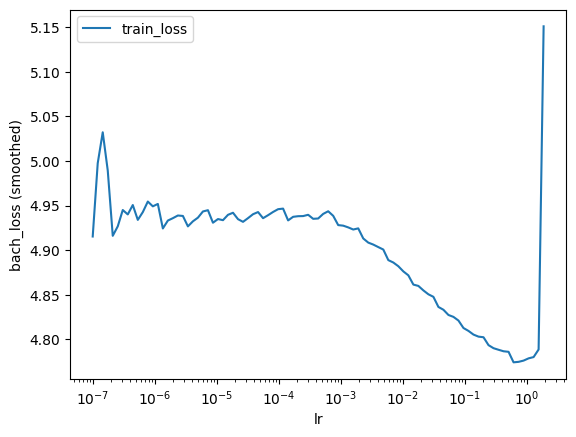

In [10]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [11]:
lrfinder.get_best_lr()

0.0613590727341321

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [12]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [13]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [14]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.7731,	val_loss: 3.9381
1:	[0s / 0s],		train_loss: 4.6650,	val_loss: 3.9277
2:	[0s / 0s],		train_loss: 4.6280,	val_loss: 3.9477
3:	[0s / 0s],		train_loss: 4.6059,	val_loss: 3.9304
4:	[0s / 0s],		train_loss: 4.6073,	val_loss: 3.9153
5:	[0s / 0s],		train_loss: 4.5785,	val_loss: 3.9085
6:	[0s / 0s],		train_loss: 4.5815,	val_loss: 3.9275
7:	[0s / 0s],		train_loss: 4.5703,	val_loss: 3.9373
8:	[0s / 0s],		train_loss: 4.5590,	val_loss: 3.9120
9:	[0s / 0s],		train_loss: 4.5697,	val_loss: 3.9082
10:	[0s / 0s],		train_loss: 4.5481,	val_loss: 3.9167
11:	[0s / 0s],		train_loss: 4.5723,	val_loss: 3.9299
12:	[0s / 0s],		train_loss: 4.5516,	val_loss: 3.9354
13:	[0s / 0s],		train_loss: 4.5546,	val_loss: 3.9446
14:	[0s / 0s],		train_loss: 4.5350,	val_loss: 3.9469
15:	[0s / 0s],		train_loss: 4.5411,	val_loss: 3.9349
16:	[0s / 0s],		train_loss: 4.5479,	val_loss: 3.9465
17:	[0s / 0s],		train_loss: 4.5435,	val_loss: 3.9697
18:	[0s / 0s],		train_loss: 4.5487,	val_loss: 3.9625
19:

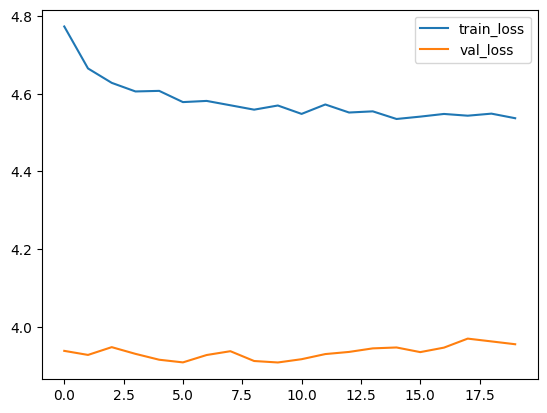

In [15]:
_ = log.plot()

We can get the partial log-likelihood

In [16]:
model.partial_log_likelihood(*val).mean()

-4.9757557

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [17]:
_ = model.compute_baseline_hazards()

In [18]:
surv = model.predict_surv_df(x_test)

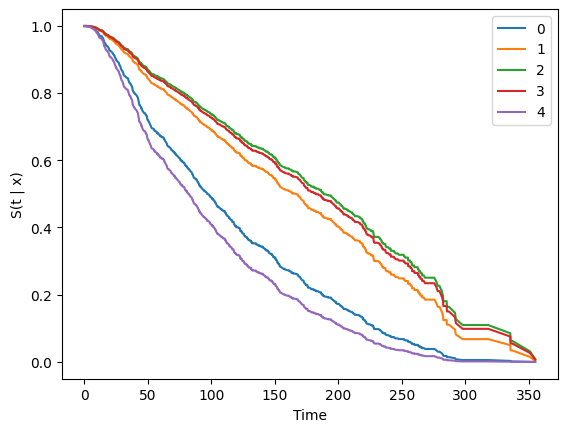

In [19]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [20]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [21]:
ev.concordance_td()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


0.6548355653500594

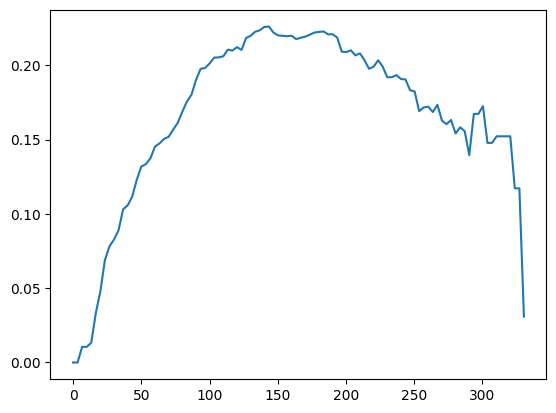

In [22]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [24]:
ev.integrated_brier_score(time_grid)

0.16736877357426813

In [25]:
ev.integrated_nbll(time_grid)

0.4951448893250452